In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from time import sleep
import requests
from selenium.webdriver.chrome.service import Service

In [2]:
chromedriver_path = "C:/Users/AdMin/Downloads/chromedriver-win64/chromedriver-win64/chromedriver.exe"

In [3]:
service = Service(chromedriver_path)
driver = webdriver.Chrome(service=service)

In [4]:
Destinations={"PAR":"Paris","MAD":"Madrid","BCN":"Barcelona","IST":"Istanbul"}
Departs={"CMN":"Casablanca","RAK":"Marrakech"}

***Pour site Kayak***

In [5]:
# Extraction des airlines
def get_airlines(soup):
    airline = []
    airlines = soup.find_all('div',class_='VY2U')
    for i in airlines:
        j = i.find('div', class_='c_cgF c_cgF-mod-variant-default')
        if j:  #Verfier si la valeur existe
            airline.append(j.text)
        else:
            airline.append(None)  # Ajouter None si le valeur n'exsite pas
    return airline
    
# Extraction des stops
def get_total_stops(soup):
    stops_list = []
    stops = soup.find_all('div',class_='JWEO')
    for i in stops:
        j=i.find('span',class_='JWEO-stops-text')
        stops_list.append(j.text)
    return stops_list
    
# Extraction des prix
def get_price(soup):
    prices = []
    price_elements2 = soup.find_all("div", attrs={"class": "f8F1-price-text"})
    price_elements2 = soup.select("div.f8F1-price-text-container div.f8F1-price-text")  # Adjust the parent class
    for element in price_elements2:
        prices.append(element.text.strip())
    return prices
    
# Extraction des durations
def get_duration(soup):
    duration_list = []
    duration = soup.find_all('div' , class_='xdW8')
    for i in duration:
        j=i.find("div",attrs={"class":"vmXl vmXl-mod-variant-default"})
        if j:  # Check if the element is found
            duration_list.append(j.text)
        else:
            duration_list.append(None)  
    return duration_list

Separer le companie d'aller et la companie de retour

In [ ]:
def remanier(compagnie):
    liste = []
    for i in range(len(compagnie)):
        if  ',' in compagnie[i] : 
            j= 0
            while compagnie[i][j]!=',' :
                j+=1
            liste.append(compagnie[i][:j])
            liste.append(compagnie[i][j+1:])
        else :
            liste.append(compagnie[i])
            liste.append(compagnie[i])
    return liste

 Dédoubler le prix pour l'aller et le retour afin qu'il n'y ait pas de problème de longueur d'array dans le DataFrame

In [ ]:
def remanier_2(prix):
    liste = []
    for i in range(len(prix)):
        liste.append(prix[i])
        liste.append(prix[i])
    return liste

In [6]:
lendurre=[]
lencompagnie=[]
lentotal_escales=[]
lenprix=[]
result = pd.DataFrame([])
prixfix=[]
for tagdepart,citydepart in Departs.items():
    for tagdestination,citydestination in Destinations.items():
        for mois in range(2,11):
            for days in range(1,29):
                # Les jours et les mois soit en 2 digits
                mois_str = f"{mois:02d}"
                days_str = f"{days:02d}"
                # Construction de l'URL en fonction du mois et du jour
                URL = f"https://www.kayak.com/flights/{tagdepart}-{tagdestination}/2025-{mois_str}-{days_str}?ucs=110wbu9&sort=bestflight_a"
                driver.get(URL)
                sleep(15)    
                #To locate the Show more button
                try:
                    show_more_button = driver.find_element_by_class_name("show-more-button")
                #To handle the Captcha
                except:
                    input("Please solve the captcha then enter[\'pO anything here to resume scraping.")
                #To click on show more
                while True:
                    try:
                        show_more_button.click()
                        driver.implicitly_wait(10)
                        show_more_button = driver.find_element_by_class_name("show-more-button")
                    except:
                        break
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                driver.quit()
                compagnie = get_airlines(soup)
                total_escales = get_total_stops(soup)
                prix = get_price(soup)
                duree = get_duration(soup)
                #parfois la methode get_prix rend une liste avec des valeurs doubles pour resoudre le problem:
                if len(prix)== 2*len(duree):
                    prixfix = prix[::2] #obtenir la deuxieme valeur
                else:
                    prixfix=prix
                #Pour verifier le longueur d'array si on a un probleme
                lendurre.append(len(duree))
                lencompagnie.append(len(compagnie))
                lentotal_escales.append(len(total_escales))
                lenprix.append(len(prix))
                #Creer le dataframe pour le lien 
                df = pd.DataFrame({'Compagnie':compagnie, "Total d'escales":total_escales , 'Prix': prixfix, 'Duree': duree}, 
                                    columns = ['Compagnie', "Total d'escales", 'Prix', 'Duree'])
                df["Depart"]=citydepart
                df["Destination"] =citydestination
                # Construire La date string en 'YYYYMMDD' format
                date_str = f"2025{mois_str}{days_str}"
                df["Date_aller"] = pd.to_datetime(date_str, format = '%Y%m%d')
                #Ajouter au dataframe finale 
                result = pd.concat([result, df], axis = 0)
                

MaxRetryError: HTTPConnectionPool(host='localhost', port=57423): Max retries exceeded with url: /session/0c85edc498033d9eaaeef22493ae7a85/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D26AB83500>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [8]:
result

,Compagnie,Total d'escales,Prix,Duree,Depart,Destination,Date_aller
0,Transavia France,nonstop,$91,3h 10m,Casablanca,Paris,2025-02-01
1,TAP AIR PORTUGAL,1 stop,$78,7h 25m,Casablanca,Paris,2025-02-01
2,TUI Fly Belgium,nonstop,$110,3h 30m,Casablanca,Paris,2025-02-01
3,Royal Air Maroc,nonstop,$166,2h 50m,Casablanca,Paris,2025-02-01
4,Royal Air Maroc,nonstop,$171,2h 50m,Casablanca,Paris,2025-02-01
...,...,...,...,...,...,...,...
12,"Vueling, Turkish Airlines",1 stop,$235,8h 00m,Marrakech,Istanbul,2025-02-01
13,"Ryanair, Pegasus Airlines",1 stop,$198,8h 50m,Marrakech,Istanbul,2025-02-01
14,Air France,1 stop,$173,12h 05m,Marrakech,Istanbul,2025-02-01
15,Royal Air Maroc,1 stop,$346,7h 45m,Marrakech,Istanbul,2025-02-01


In [17]:
#Ajouter column du jour
result['jour_semaine'] = result['Date_aller'].dt.day_name()
#Ajouter column du mois
result['mois'] = result['Date_aller'].dt.month
#Supprimer les caractères non numériques comme ',' et '$' et convertir en float
result['Prix'] = result['Prix'].str.replace('[^\d]', '', regex=True).astype(float)
#Convertie le Prix du $ en DH
result['Prix'] = result['Prix']*10
#Chnger le nom du column
result.rename(columns={'Prix': 'Prix_DH'}, inplace=True)
result

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\AdMin\AppData\Local\Temp\ipykernel_3784\945719718.py:3: SyntaxWarning: invalid escape sequence '\d'
  result['Prix'] = result['Prix'].str.replace('[^\d]', '', regex=True).astype(float)


,Compagnie,Total d'escales,Prix_DH,Duree,Depart,Destination,Date_aller,jour_semaine,mois
0,Transavia France,nonstop,913.64,3h 10m,Casablanca,Paris,2025-02-01,Saturday,2
1,TAP AIR PORTUGAL,1 stop,783.12,7h 25m,Casablanca,Paris,2025-02-01,Saturday,2
2,TUI Fly Belgium,nonstop,1104.40,3h 30m,Casablanca,Paris,2025-02-01,Saturday,2
3,Royal Air Maroc,nonstop,1666.64,2h 50m,Casablanca,Paris,2025-02-01,Saturday,2
4,Royal Air Maroc,nonstop,1716.84,2h 50m,Casablanca,Paris,2025-02-01,Saturday,2
...,...,...,...,...,...,...,...,...,...
12,"Vueling, Turkish Airlines",1 stop,2359.40,8h 00m,Marrakech,Istanbul,2025-02-01,Saturday,2
13,"Ryanair, Pegasus Airlines",1 stop,1987.92,8h 50m,Marrakech,Istanbul,2025-02-01,Saturday,2
14,Air France,1 stop,1736.92,12h 05m,Marrakech,Istanbul,2025-02-01,Saturday,2
15,Royal Air Maroc,1 stop,3473.84,7h 45m,Marrakech,Istanbul,2025-02-01,Saturday,2


In [ ]:
result.to_csv('data_avion.csv', index=False) 

In [19]:
#Analyse des tendances par jour du semaine
prix_par_jour = result.groupby('jour_semaine')['Prix_DH'].mean().sort_values()
prix_par_jour

jour_semaine
Saturday    1626.559683
Name: Prix_DH, dtype: float64

In [20]:
#Analyse des tendances par mois
prix_par_mois = result.groupby('mois')['Prix_DH'].mean().sort_values()
prix_par_mois

mois
2    1626.559683
Name: Prix_DH, dtype: float64

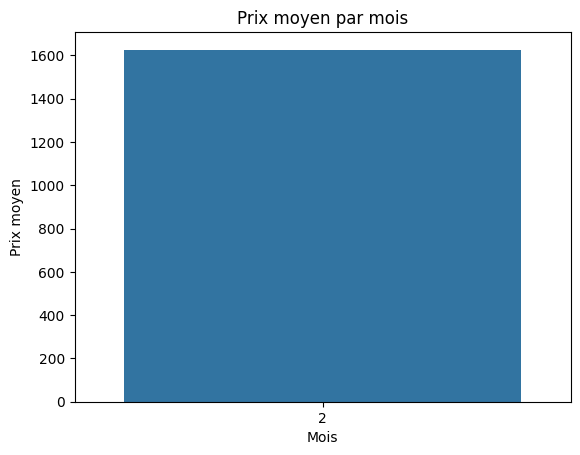

In [22]:
#Visualiser les tendances
sns.barplot(x=prix_par_mois.index, y=prix_par_mois.values)
plt.title('Prix moyen par mois')
plt.xlabel('Mois')
plt.ylabel('Prix moyen')
plt.show()

In [25]:
#Prix moyen par destination et lieu de départ
prix_par_destination = result.groupby(['Destination', 'Depart'])['Prix_DH'].mean()
prix_par_destination

Destination  Depart    
Barcelona    Casablanca    1331.555000
             Marrakech     2001.976000
Istanbul     Casablanca    3077.260000
             Marrakech     2042.254118
Madrid       Casablanca    1283.237500
             Marrakech      761.701333
Paris        Casablanca    1769.717333
             Marrakech      697.152500
Name: Prix_DH, dtype: float64

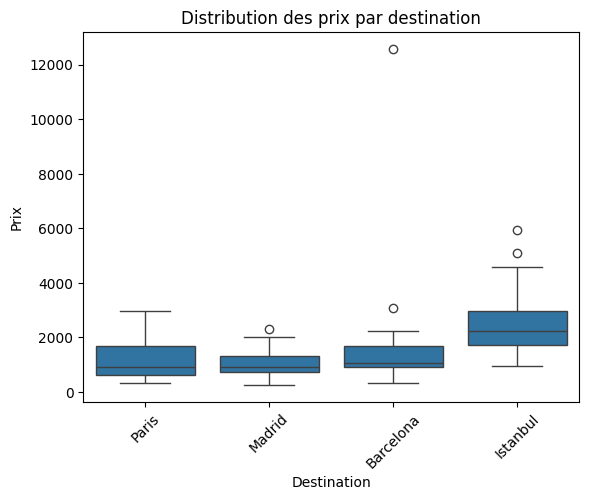

In [37]:
#Representation graphique des moyens
sns.boxplot(x='Destination', y='Prix_DH', data=result)
plt.title('Distribution des prix par destination')
plt.xlabel('Destination')
plt.ylabel('Prix')
plt.xticks(rotation=45)  # Inclinez les labels pour une meilleure lisibilité
plt.show()

In [28]:
#Calculez la variation de prix d’un jour à l’autre 
result['variation_prix'] = result['Prix_DH'].diff()
result

,Compagnie,Total d'escales,Prix_DH,Duree,Depart,Destination,Date_aller,jour_semaine,mois,variation_prix
0,Transavia France,nonstop,913.64,3h 10m,Casablanca,Paris,2025-02-01,Saturday,2,NaN
1,TAP AIR PORTUGAL,1 stop,783.12,7h 25m,Casablanca,Paris,2025-02-01,Saturday,2,-130.52
2,TUI Fly Belgium,nonstop,1104.40,3h 30m,Casablanca,Paris,2025-02-01,Saturday,2,321.28
3,Royal Air Maroc,nonstop,1666.64,2h 50m,Casablanca,Paris,2025-02-01,Saturday,2,562.24
4,Royal Air Maroc,nonstop,1716.84,2h 50m,Casablanca,Paris,2025-02-01,Saturday,2,50.20
...,...,...,...,...,...,...,...,...,...,...
12,"Vueling, Turkish Airlines",1 stop,2359.40,8h 00m,Marrakech,Istanbul,2025-02-01,Saturday,2,1074.28
13,"Ryanair, Pegasus Airlines",1 stop,1987.92,8h 50m,Marrakech,Istanbul,2025-02-01,Saturday,2,-371.48
14,Air France,1 stop,1736.92,12h 05m,Marrakech,Istanbul,2025-02-01,Saturday,2,-251.00
15,Royal Air Maroc,1 stop,3473.84,7h 45m,Marrakech,Istanbul,2025-02-01,Saturday,2,1736.92


In [32]:
#Identifier les dates avec les prix les plus bas
prix_minimum = result.loc[result['Prix_DH'] == result['Prix_DH'].min()]
prix_minimum

,Compagnie,Total d'escales,Prix_DH,Duree,Depart,Destination,Date_aller,jour_semaine,mois,variation_prix
0,Ryanair,nonstop,261.04,2h 05m,Marrakech,Madrid,2025-02-01,Saturday,2,-1014.04


In [33]:
#Identifier les meilleures périodes par destination
df_meilleurs_moments = result.groupby(['Depart','Destination', 'mois'])['Prix_DH'].mean().reset_index()
print(df_meilleurs_moments)

       Depart Destination  mois      Prix_DH
0  Casablanca   Barcelona     2  1331.555000
1  Casablanca    Istanbul     2  3077.260000
2  Casablanca      Madrid     2  1283.237500
3  Casablanca       Paris     2  1769.717333
4   Marrakech   Barcelona     2  2001.976000
5   Marrakech    Istanbul     2  2042.254118
6   Marrakech      Madrid     2   761.701333
7   Marrakech       Paris     2   697.152500


In [34]:
#Classez les destinations selon leur accessibilité
destinations_les_moins_cheres = result.groupby(["Depart",'Destination'])['Prix_DH'].mean().sort_values()
print(destinations_les_moins_cheres)

Depart      Destination
Marrakech   Paris           697.152500
            Madrid          761.701333
Casablanca  Madrid         1283.237500
            Barcelona      1331.555000
            Paris          1769.717333
Marrakech   Barcelona      2001.976000
            Istanbul       2042.254118
Casablanca  Istanbul       3077.260000
Name: Prix_DH, dtype: float64


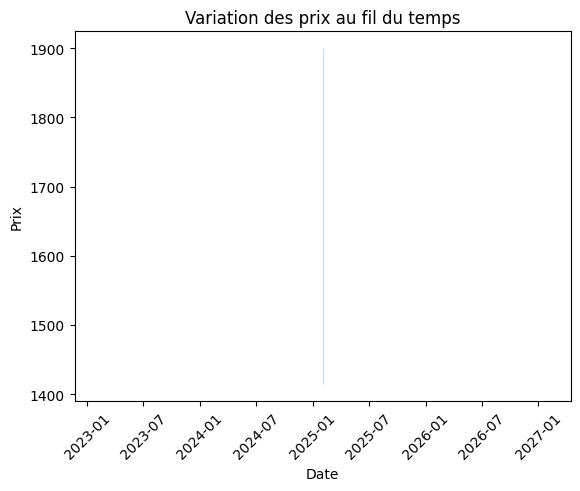

In [39]:
#Visualisation des prix selon les dates
sns.lineplot(x='Date_aller', y='Prix_DH', data=result)
plt.title('Variation des prix au fil du temps')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.xticks(rotation=45)  # Inclinez les labels pour une meilleure lisibilité
plt.show()